PyGeNN Tutorial: Ring of neurons
===========================

Load some standard libraries and the needed elements of PyGeNN
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pygenn.genn_model import (GeNNModel, init_connectivity, create_cmlf_class,
                               create_custom_sparse_connect_init_snippet_class,
                               create_custom_neuron_class)
from pygenn.genn_wrapper import NO_DELAY

Create the model class and set the time step
---

In [2]:
model = GeNNModel("float", "LIFRing")
model.dT = 0.1

Define an initialisation code snippet
---

In [3]:
ring_model = create_custom_sparse_connect_init_snippet_class(
    "ring",
    row_build_code=
        """
        $(addSynapse, ($(id_pre) + 1) % $(num_post));
        $(endRow);
        """,
    calc_max_row_len_func=create_cmlf_class(
        lambda num_pre, num_post, pars: 1)())

Define a custom neuron model
---

In [4]:
adaptive_LIF = create_custom_neuron_class(
    "adaptive_LIF",
    param_names= ["C_mem", "V_reset", "V_thresh", "V_leak", "g_leak", "r_scale", "g_adapt", "V_adapt", "tau_adapt", "noise_A"],
    var_name_types= [("V", "scalar"), ("a", "scalar")],
    sim_code= """
    $(V)+= (-$(g_leak)*($(V)-$(V_leak)) - $(g_adapt)*$(a)*($(V)-$(V_adapt)) 
            + $(r_scale)*$(Isyn)+$(noise_A)*$(gennrand_normal))*DT/$(C_mem);
    $(a)+= -$(a)*DT/$(tau_adapt);
    """,
    threshold_condition_code= """
    $(V) >= $(V_thresh)
    """,
    reset_code= """
    $(V)= $(V_reset);
    $(a)+= 0.3;
    """
    )

Define some neuron parameters and initial variables
---

In [5]:
N = 10
p = {"C_mem": 2.0,
             "V_reset": -70.0,
             "V_thresh": -40.0,
             "V_leak": -60.0,
             "g_leak": 0.01,
             "r_scale": 1.0,
             "g_adapt": 0.005,
             "V_adapt": -70.0,
             "tau_adapt": 1000.0,
             "noise_A": 0.5/np.sqrt(model.dT)
             }

ini = {"V": -60.0,
          "a": 0.0
          }

stim_ini = {"startSpike": [0], "endSpike": [1]}

Define some synaptic parameters and initial values
---

In [6]:
s_ini = {"g": 0.18}

ps_p = {"tau": 5.0,  # Decay time constant [ms] 
        "E": 10.0}  # Reversal potential [mV]

Add a neuron population and stimulus population
---

In [7]:
pop1 = model.add_neuron_population("Pop1", N, adaptive_LIF, p, ini)
stim = model.add_neuron_population("Stim", 1, "SpikeSourceArray", {}, stim_ini)

Add a synapse population: 
---
Connect the LIF neurons in a ring with the "ring" init snippet


In [8]:
syn1 = model.add_synapse_population("Pop1self", "SPARSE_GLOBALG", 10,
    pop1, pop1,
    "StaticPulse", {}, s_ini, {}, {},
    "ExpCond", ps_p, {},
    init_connectivity(ring_model, {}))

Add a second synapse population: 
---
Connect the stimuli to the neurons

In [9]:
model.add_synapse_population("StimPop1", "SPARSE_GLOBALG", NO_DELAY,
    stim, pop1,
    "StaticPulse", {}, s_ini, {}, {},
    "ExpCond", ps_p, {},
    init_connectivity("OneToOne", {}))

Initialize the spike source array
---

In [10]:
stim.set_extra_global_param("spikeTimes", [0.0])

Build the model
---
This step does the entire code generation and C++/CUDA compilation!

In [11]:
m = model.build()

Load the model
---
This step will initialize the model

In [12]:
model.load()

Run the model for some time steps
---

In [13]:
v = np.empty((4000, N))
v_view = pop1.vars["V"].view
while model.t < 400.0:
    model.step_time()
    pop1.pull_var_from_device("V")
    
    v[model.timestep - 1,:]=v_view[:]

Plot the results
---

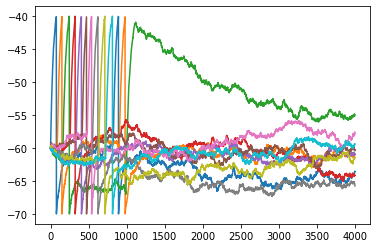

In [14]:
fig, axis = plt.subplots()
axis.plot(v[:,:])
#plt.xlim((0,250))
plt.show()